In [1]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from sklearn import decomposition

In [2]:
# Task 1-1. 
# 파일을 다운로드 받고 ua.data 파일(학습데이터)과 ua.test 파일(검증데이터)의 내용을 불러와서 Tensor 데이터 생성하기

train = pd.read_csv("./ua.base", sep="\t", names=['user', 'movieId', 'rating'], usecols = [0,1,2])
test = pd.read_csv("./ua.test", sep="\t", names=['user', 'movieId', 'rating'], usecols = [0,1,2])

items = torch.LongTensor(train['movieId'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

items_test = torch.LongTensor(test['movieId'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

train

,user,movieId,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
...,...,...,...
90565,943,1047,2
90566,943,1074,4
90567,943,1188,3
90568,943,1228,3


In [3]:
# Task 1-2.
# u.item 파일로부터 영화 id와 title 불러오기

meta = pd.read_csv('./u.item', sep='|', names=['movieId', 'title'], encoding='latin-1', usecols = [0,1])
meta

,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [5]:
# Task 2. 
# Latent Factor 모델을 이용하여 학습하기

rank = 10
numItems = items.max()+1
numUsers = users.max()+1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
mean = ratings.sum()/len(ratings)

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

X = []
Y = []
Y_test = []
for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean +\
    bias_item[items] + bias_user[users]
  rmse = F.mse_loss(hypothesis, ratings) ** 0.5 
  cost = rmse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() +\
    lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()
    
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean +\
      bias_item[items_test] + bias_user[users_test]
    rmse_test = F.mse_loss(hypo_test, ratings_test) ** 0.5

    X.append(epoch)
    Y.append(rmse.item())
    Y_test.append(rmse_test.item())

  if epoch % 100 == 0:
    print(f"epoch: {epoch}, rmse:{rmse.item():.6f}, rmse_test:{rmse_test.item():.6f}") 

epoch: 0, rmse:3.684302, rmse_test:3.204948
epoch: 100, rmse:0.843425, rmse_test:0.976067
epoch: 200, rmse:0.838504, rmse_test:0.974294
epoch: 300, rmse:0.837945, rmse_test:0.973748
epoch: 400, rmse:0.837473, rmse_test:0.973191
epoch: 500, rmse:0.837305, rmse_test:0.972979
epoch: 600, rmse:0.837236, rmse_test:0.972963
epoch: 700, rmse:0.837219, rmse_test:0.972975
epoch: 800, rmse:0.837190, rmse_test:0.972988
epoch: 900, rmse:0.837192, rmse_test:0.972972
epoch: 1000, rmse:0.837171, rmse_test:0.972999


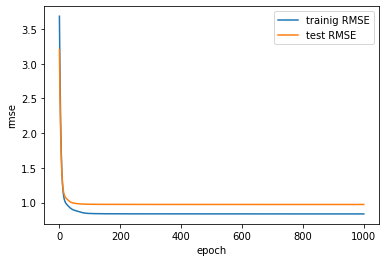

In [6]:
# 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기 (training RMSE, test RMSE)

plt.xlabel("epoch")
plt.ylabel("rmse")
plt.plot(X, Y, label="trainig RMSE")
plt.plot(X, Y_test, label="test RMSE")
plt.legend()
plt.show()

In [7]:
# Task 3-1.
# 13번 user의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기

def find_top_ratings(user, n):
  result=[]
  for id in range(len(P)):
    r = torch.sum(P[id]*Q[user])+mean+bias_item[id]+bias_user[user]
    result.append([r, id])

  result.sort(key=lambda r: r[0], reverse=True)
  result = result[:n]

  topRating = [r[0].tolist() for r in result]
  topId = [r[1] for r in result]
  idx = [r[1]-1 for r in result]

  top = meta.loc[idx, :]
  top['ratings'] = topRating

  return top, topId

topMovie, topRatingId = find_top_ratings(13, 20)
topMovie

,movieId,title,ratings
49,50,Star Wars (1977),6.105910
180,181,Return of the Jedi (1983),5.862376
171,172,"Empire Strikes Back, The (1980)",5.595942
99,100,Fargo (1996),5.483088
126,127,"Godfather, The (1972)",5.450182
134,135,2001: A Space Odyssey (1968),5.441113
173,174,Raiders of the Lost Ark (1981),5.345479
510,511,Lawrence of Arabia (1962),5.340308
275,276,Leaving Las Vegas (1995),5.267093
186,187,"Godfather: Part II, The (1974)",5.214191


In [80]:
# Task 3-2. 
# Latent Matrix P와 Q를 이용하여 13번 user와 cosine similarity가 가장 유사한 영화 top 20개를 찾아서 id 및 영화이름 출력하기

Pn = P.detach().numpy()
Qn = Q.detach().numpy()

def cosine_similarity(u1, u2):
  denom = ((u1 ** 2).sum() * (u2 ** 2).sum()) ** 0.5
  if denom == 0:
    return 0
  else:
    return (u1 * u2).sum() / denom

def find_top_cosine(user, n):
  result=[]
  for id in range(1,len(Pn)):
    cosine = cosine_similarity(Qn[user], Pn[id])
    r = np.sum(Pn[id]*Qn[user])+mean+bias_item[id]+bias_user[user]
    result.append([cosine, r, id])

  result.sort(key=lambda r: r[0], reverse=True)
  result = result[:n]
  topCosine = [r[0].tolist() for r in result]
  topRating = [r[1].tolist() for r in result]
  topId = [r[2] for r in result]
  idx = [r[2]-1 for r in result]

  top = meta.loc[idx, :]
  top['cosine'] = topCosine
  top['ratings'] = topRating

  return top, topId

topCosine, topCosineId = find_top_cosine(13, 20)
topCosine

,movieId,title,cosine,ratings
813,814,"Great Day in Harlem, A (1994)",0.999999,4.130960
867,868,Hearts and Minds (1996),0.975575,4.212038
908,909,Dangerous Beauty (1998),0.943525,4.129967
847,848,"Murder, My Sweet (1944)",0.938406,4.057985
866,867,"Whole Wide World, The (1996)",0.915121,4.247302
916,917,Mercury Rising (1998),0.823526,3.649043
810,811,Thirty-Two Short Films About Glenn Gould (1993),0.817093,4.165638
899,900,Kundun (1997),0.775501,4.169262
914,915,Primary Colors (1998),0.722324,4.159462
389,390,Fear of a Black Hat (1993),0.680275,4.108013


In [81]:
# Task 4-1.
# 다음을 만족하는 k-means clustering알고리즘 구현하기
# 각 영화가 속한 cluster를 정할 때, cosine similarity를 기준으로 정하기

def assign(p, centroids):
  min_c_idx = -1
  min_c_dist = 99*99
  
  for i, c in enumerate(centroids):
    dist = 1 - cosine_similarity(p, c)
    
    if min_c_dist > dist:
      min_c_dist = dist
      min_c_idx = i

  return min_c_idx

def compute_centroids(k, points, assignments):
  cluster = [ [0] for _ in range(k) ]
  for a, p in zip(assignments, points):
    cluster[a].append(p)

  return [ np.mean(c, axis=0) for c in cluster ]
  
def kmeans(k, points):
  
  prev_assignment = []

  centroids = random.choices(points, k=k)
  
  for epoch in range(10):
    assignments = [assign(p, centroids) for p in points]
    
    centroids = compute_centroids(k, points, assignments)

    if prev_assignment == assignments: break
    prev_assignment = assignments
    
  return assignments, centroids

100%|██████████| 40/40 [04:00<00:00,  6.01s/it]


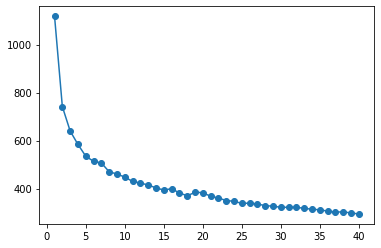

In [83]:
# Task 4-2.
# k=1, ..., 40 까지 바꿔가면서 cost 값을 계산하고 이를 matplotlib을 활용하여 그래프로 그리기

cost = []
for k in tqdm(range(1,41)):
  assignments, centroids = kmeans(k, Pn)
  dist = 0
  for a, x in zip(assignments, Pn):
    dist += (1 - cosine_similarity(x, centroids[a]))
  cost.append(dist)

plt.plot(range(1,41), cost, '-o')
plt.show()

In [93]:
# Task 4-3. 
# 가장 적절해보이는 k 선택하기

assignments, centroids = kmeans(3, Pn)

In [85]:
# Task 5-1. 5-2.
# P 행렬와 Q 행렬을 합쳐 Z행렬 만들기
Z = torch.cat((P, Q), 0)
Z = Z.detach().numpy()

# Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기
pca = decomposition.PCA(2)
pca.fit(Z)
Zp = pca.transform(Z)

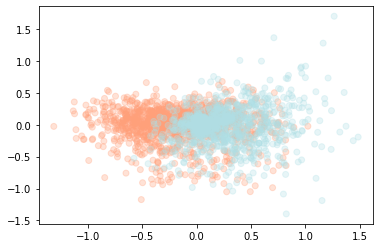

In [86]:
# Task 5-3-1. 
# P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기

sp = ['P']*len(P) + ['Q']*len(Q)
species = {'P':'lightsalmon', 'Q':'powderblue'}
plt.scatter(Zp[:,0], Zp[:,1], c=[species[a] for a in sp], alpha=0.3)
plt.show()

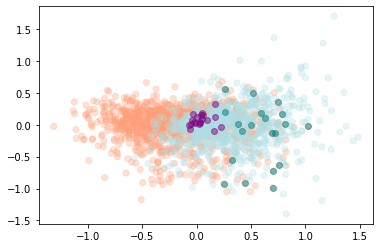

In [87]:
# Task 5-3-2. 
# Task 3의 결과 점들을 다른 색으로 그려 강조하기

plt.scatter(Zp[:,0], Zp[:,1], c=[species[a] for a in sp], alpha=0.3)
plt.scatter(Zp[topRatingId,0], Zp[topRatingId,1], c='teal', alpha=0.5)
plt.scatter(Zp[topCosineId,0], Zp[topCosineId,1], c='purple', alpha=0.5)
plt.show()

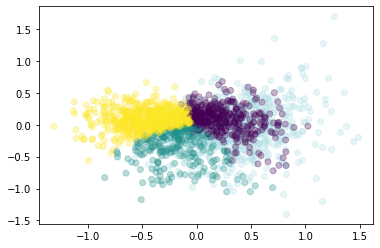

In [94]:
# Task 5-3-3.
# Task 4에서 구한 cluster들을 각기 다른 색으로 그리기

plt.scatter(Zp[len(P):,0], Zp[len(P):,1], c='powderblue', alpha=0.3)

speciesP = {s:i for i,s in enumerate(set(assignments))}
plt.scatter(Zp[:len(P),0], Zp[:len(P),1], c=[speciesP[a] for a in assignments], alpha=0.3)

plt.show()